# VVIX/VIX Ratio Strategy Analysis

This notebook investigates the relationship between the VVIX/VIX ratio and market returns, specifically looking at how declining ratios correlate with increased market returns.

## Strategy Hypothesis
- When VVIX/VIX ratio decreases, it may signal reduced volatility expectations
- This could indicate market confidence and potentially higher returns
- We'll analyze historical data to test this relationship


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## Data Collection

We'll collect data for:
- VIX (CBOE Volatility Index)
- VVIX (CBOE VVIX Index) 
- SPY (S&P 500 ETF) for market returns


In [2]:
# Define date range (last 5 years for comprehensive analysis)
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"Collecting data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Download data
tickers = ['^VIX', '^VVIX', 'SPY']
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

print(f"Data shape: {data.shape}")
print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
print("\nFirst few rows:")
print(data.head())


Data shape: (1256, 15)
Date range: 2020-10-26 to 2025-10-24

First few rows:
Price            Close                               High                     \
Ticker             SPY       ^VIX       ^VVIX         SPY   ^VIX       ^VVIX   
Date                                                                           
2020-10-26  316.399994  32.459999  133.080002  319.746807  33.68  135.220001   
2020-10-27  315.309174  33.349998  135.320007  317.080463  33.77  137.520004   
2020-10-28  304.532288  40.279999  152.009995  315.337186  40.77  154.990005   
2020-10-29  307.627441  37.590000  147.839996  310.815758  41.16  151.669998   
2020-10-30  304.420410  38.020000  145.240005  307.357026  41.09  150.960007   

Price              Low                               Open             \
Ticker             SPY       ^VIX       ^VVIX         SPY       ^VIX   
Date                                                                   
2020-10-26  312.885353  29.219999  121.300003  318.954379  29.3799

## Data Processing and Ratio Calculation


In [3]:
# Extract closing prices
vix_close = data['Close']['^VIX'].dropna()
vvix_close = data['Close']['^VVIX'].dropna()
spy_close = data['Close']['SPY'].dropna()

# Align all series to common dates
common_dates = vix_close.index.intersection(vvix_close.index).intersection(spy_close.index)

vix_aligned = vix_close.loc[common_dates]
vvix_aligned = vvix_close.loc[common_dates]
spy_aligned = spy_close.loc[common_dates]

# Calculate VVIX/VIX ratio
ratio = vvix_aligned / vix_aligned

# Calculate SPY returns (daily and forward-looking)
spy_returns = spy_aligned.pct_change().dropna()
spy_returns_5d = spy_aligned.pct_change(5).dropna()  # 5-day forward returns
spy_returns_10d = spy_aligned.pct_change(10).dropna()  # 10-day forward returns
spy_returns_20d = spy_aligned.pct_change(20).dropna()  # 20-day forward returns

print(f"Data points after alignment: {len(common_dates)}")
print(f"\nVVIX/VIX Ratio Statistics:")
print(ratio.describe())
print(f"\nSPY Returns Statistics:")
print(spy_returns.describe())


Data points after alignment: 1250

VVIX/VIX Ratio Statistics:
count    1250.000000
mean        5.374041
std         1.040173
min         2.883082
25%         4.649054
50%         5.568800
75%         6.188668
max         7.625243
dtype: float64

SPY Returns Statistics:
count    1249.000000
mean        0.000669
std         0.010890
min        -0.058543
25%        -0.004477
50%         0.000777
75%         0.006373
max         0.105019
Name: SPY, dtype: float64


## Exploratory Data Analysis


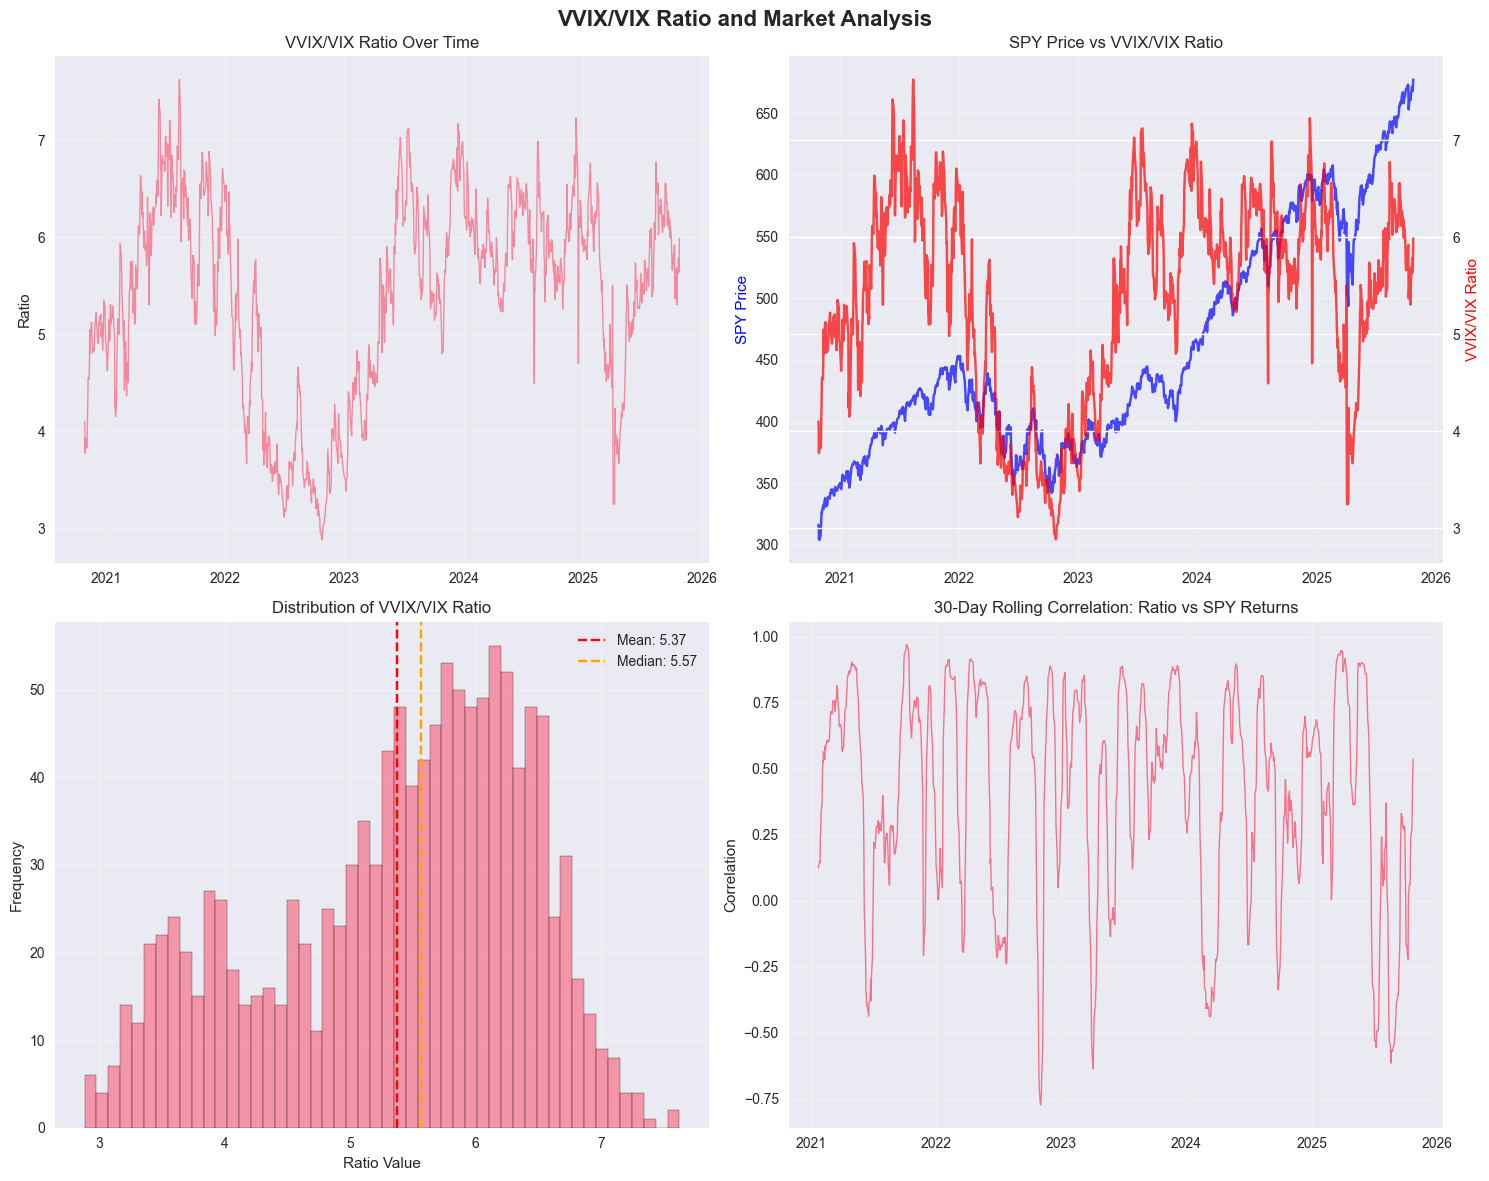

In [4]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('VVIX/VIX Ratio and Market Analysis', fontsize=16, fontweight='bold')

# Plot 1: Time series of VVIX/VIX ratio
axes[0, 0].plot(ratio.index, ratio.values, linewidth=1, alpha=0.8)
axes[0, 0].set_title('VVIX/VIX Ratio Over Time')
axes[0, 0].set_ylabel('Ratio')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: SPY price and ratio overlay
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()
ax2.plot(spy_aligned.index, spy_aligned.values, color='blue', alpha=0.7, label='SPY Price')
ax2_twin.plot(ratio.index, ratio.values, color='red', alpha=0.7, label='VVIX/VIX Ratio')
ax2.set_title('SPY Price vs VVIX/VIX Ratio')
ax2.set_ylabel('SPY Price', color='blue')
ax2_twin.set_ylabel('VVIX/VIX Ratio', color='red')
ax2.grid(True, alpha=0.3)

# Plot 3: Distribution of the ratio
axes[1, 0].hist(ratio.dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(ratio.mean(), color='red', linestyle='--', label=f'Mean: {ratio.mean():.2f}')
axes[1, 0].axvline(ratio.median(), color='orange', linestyle='--', label=f'Median: {ratio.median():.2f}')
axes[1, 0].set_title('Distribution of VVIX/VIX Ratio')
axes[1, 0].set_xlabel('Ratio Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Rolling correlation
rolling_corr = ratio.rolling(30).corr(spy_returns.rolling(30).mean())
axes[1, 1].plot(rolling_corr.index, rolling_corr.values, linewidth=1)
axes[1, 1].set_title('30-Day Rolling Correlation: Ratio vs SPY Returns')
axes[1, 1].set_ylabel('Correlation')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Correlation Analysis

Let's analyze the relationship between VVIX/VIX ratio changes and future market returns.


Correlation Analysis:
Ratio vs SPY Return (1d): 0.0820
Ratio vs SPY Return (5d): 0.1965
Ratio vs SPY Return (10d): 0.3005
Ratio vs SPY Return (20d): 0.4094
Ratio Change vs SPY Return (1d): 0.5666
Ratio Change vs SPY Return (5d): 0.2585
Ratio Change vs SPY Return (10d): 0.2052
Ratio Change vs SPY Return (20d): 0.1136


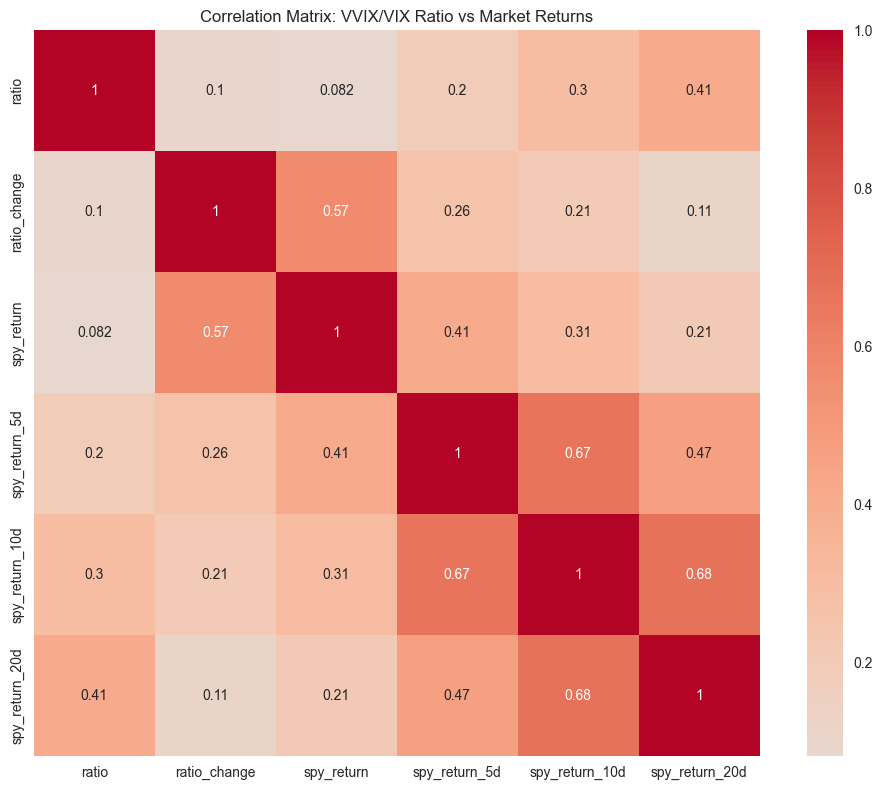

In [5]:
# Calculate ratio changes
ratio_change = ratio.pct_change().dropna()
ratio_change_5d = ratio.pct_change(5).dropna()
ratio_change_10d = ratio.pct_change(10).dropna()

# Align data for correlation analysis
analysis_data = pd.DataFrame({
    'ratio': ratio,
    'ratio_change': ratio_change,
    'spy_return': spy_returns,
    'spy_return_5d': spy_returns_5d,
    'spy_return_10d': spy_returns_10d,
    'spy_return_20d': spy_returns_20d
}).dropna()

print("Correlation Analysis:")
print("=" * 50)

# Calculate correlations
correlations = {
    'Ratio vs SPY Return (1d)': analysis_data['ratio'].corr(analysis_data['spy_return']),
    'Ratio vs SPY Return (5d)': analysis_data['ratio'].corr(analysis_data['spy_return_5d']),
    'Ratio vs SPY Return (10d)': analysis_data['ratio'].corr(analysis_data['spy_return_10d']),
    'Ratio vs SPY Return (20d)': analysis_data['ratio'].corr(analysis_data['spy_return_20d']),
    'Ratio Change vs SPY Return (1d)': analysis_data['ratio_change'].corr(analysis_data['spy_return']),
    'Ratio Change vs SPY Return (5d)': analysis_data['ratio_change'].corr(analysis_data['spy_return_5d']),
    'Ratio Change vs SPY Return (10d)': analysis_data['ratio_change'].corr(analysis_data['spy_return_10d']),
    'Ratio Change vs SPY Return (20d)': analysis_data['ratio_change'].corr(analysis_data['spy_return_20d'])
}

for key, value in correlations.items():
    print(f"{key}: {value:.4f}")

# Create correlation heatmap
corr_matrix = analysis_data[['ratio', 'ratio_change', 'spy_return', 'spy_return_5d', 'spy_return_10d', 'spy_return_20d']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix: VVIX/VIX Ratio vs Market Returns')
plt.tight_layout()
plt.show()


## Strategy Analysis: Ratio Decline and Market Returns

Let's investigate what happens when the VVIX/VIX ratio declines significantly.


In [6]:
# Define threshold for "significant decline" (bottom 20th percentile)
decline_threshold = ratio.quantile(0.2)
print(f"Decline threshold (20th percentile): {decline_threshold:.4f}")

# Identify periods of significant ratio decline
decline_periods = ratio < decline_threshold
decline_dates = ratio[decline_periods].index

print(f"Number of days with significant ratio decline: {len(decline_dates)}")
print(f"Percentage of total days: {len(decline_dates)/len(ratio)*100:.2f}%")

# Analyze returns during decline periods vs normal periods
normal_periods = ratio >= decline_threshold

# Calculate average returns for different scenarios
scenarios = {
    'All Periods': {
        '1d_return': spy_returns.mean(),
        '5d_return': spy_returns_5d.mean(),
        '10d_return': spy_returns_10d.mean(),
        '20d_return': spy_returns_20d.mean()
    },
    'Ratio Decline Periods': {
        '1d_return': spy_returns[decline_periods].mean(),
        '5d_return': spy_returns_5d[decline_periods].mean(),
        '10d_return': spy_returns_10d[decline_periods].mean(),
        '20d_return': spy_returns_20d[decline_periods].mean()
    },
    'Normal Periods': {
        '1d_return': spy_returns[normal_periods].mean(),
        '5d_return': spy_returns_5d[normal_periods].mean(),
        '10d_return': spy_returns_10d[normal_periods].mean(),
        '20d_return': spy_returns_20d[normal_periods].mean()
    }
}

# Create comparison table
comparison_df = pd.DataFrame(scenarios).T
comparison_df = comparison_df * 100  # Convert to percentage

print("\nAverage Returns by Scenario (%):")
print(comparison_df.round(4))

# Calculate outperformance
outperformance = comparison_df.loc['Ratio Decline Periods'] - comparison_df.loc['Normal Periods']
print("\nOutperformance of Decline Periods vs Normal Periods (%):")
print(outperformance.round(4))


Decline threshold (20th percentile): 4.3285
Number of days with significant ratio decline: 250
Percentage of total days: 20.00%

Average Returns by Scenario (%):
                       1d_return  5d_return  10d_return  20d_return
All Periods               0.0669     0.3377      0.6572      1.2749
Ratio Decline Periods    -0.0217    -0.2956     -0.7521     -1.7681
Normal Periods            0.0889     0.4928      0.9972      2.0164

Outperformance of Decline Periods vs Normal Periods (%):
1d_return    -0.1106
5d_return    -0.7884
10d_return   -1.7493
20d_return   -3.7845
dtype: float64


## Visualization of Strategy Performance


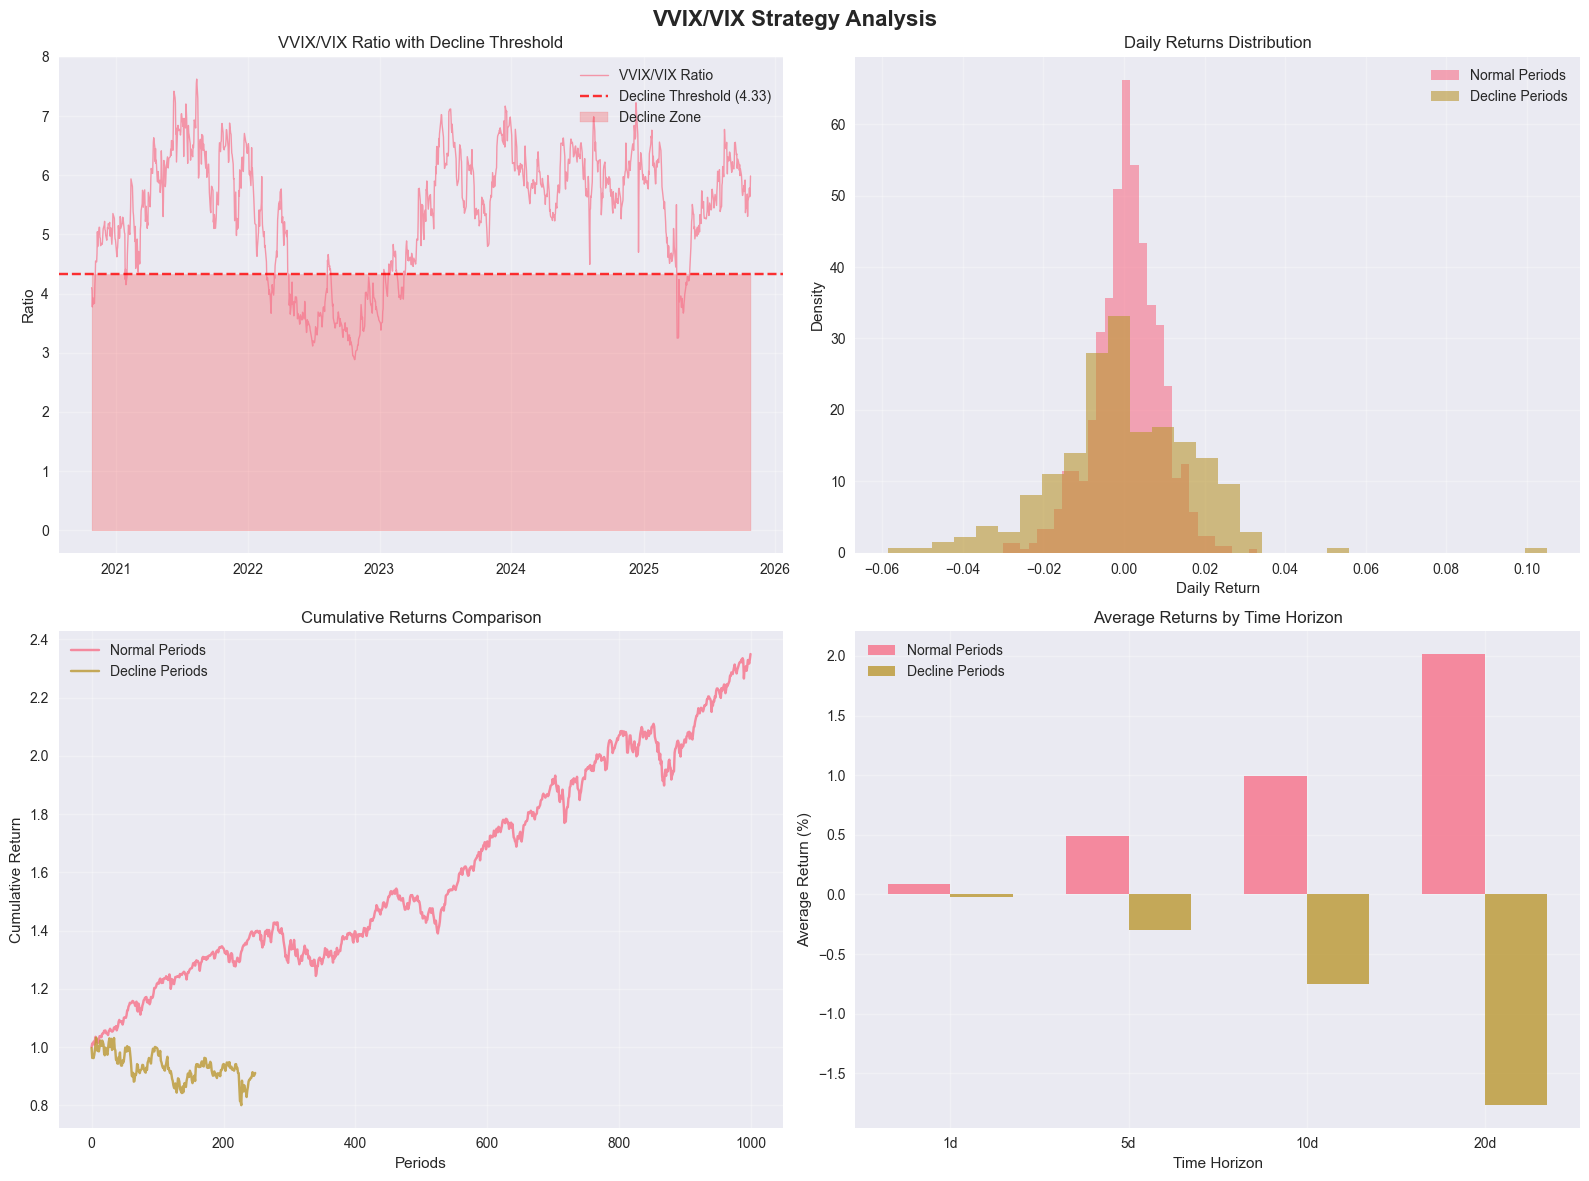

In [7]:
# Create comprehensive strategy visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('VVIX/VIX Strategy Analysis', fontsize=16, fontweight='bold')

# Plot 1: Ratio with decline periods highlighted
axes[0, 0].plot(ratio.index, ratio.values, alpha=0.7, linewidth=1, label='VVIX/VIX Ratio')
axes[0, 0].axhline(y=decline_threshold, color='red', linestyle='--', alpha=0.8, label=f'Decline Threshold ({decline_threshold:.2f})')
axes[0, 0].fill_between(ratio.index, 0, decline_threshold, alpha=0.2, color='red', label='Decline Zone')
axes[0, 0].set_title('VVIX/VIX Ratio with Decline Threshold')
axes[0, 0].set_ylabel('Ratio')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Returns distribution comparison
axes[0, 1].hist(spy_returns[normal_periods], bins=30, alpha=0.6, label='Normal Periods', density=True)
axes[0, 1].hist(spy_returns[decline_periods], bins=30, alpha=0.6, label='Decline Periods', density=True)
axes[0, 1].set_title('Daily Returns Distribution')
axes[0, 1].set_xlabel('Daily Return')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Cumulative returns comparison
normal_cumret = (1 + spy_returns[normal_periods]).cumprod()
decline_cumret = (1 + spy_returns[decline_periods]).cumprod()

axes[1, 0].plot(range(len(normal_cumret)), normal_cumret.values, label='Normal Periods', alpha=0.8)
axes[1, 0].plot(range(len(decline_cumret)), decline_cumret.values, label='Decline Periods', alpha=0.8)
axes[1, 0].set_title('Cumulative Returns Comparison')
axes[1, 0].set_xlabel('Periods')
axes[1, 0].set_ylabel('Cumulative Return')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Performance metrics comparison
metrics = ['1d_return', '5d_return', '10d_return', '20d_return']
normal_returns = [comparison_df.loc['Normal Periods', metric] for metric in metrics]
decline_returns = [comparison_df.loc['Ratio Decline Periods', metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x - width/2, normal_returns, width, label='Normal Periods', alpha=0.8)
axes[1, 1].bar(x + width/2, decline_returns, width, label='Decline Periods', alpha=0.8)
axes[1, 1].set_title('Average Returns by Time Horizon')
axes[1, 1].set_xlabel('Time Horizon')
axes[1, 1].set_ylabel('Average Return (%)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['1d', '5d', '10d', '20d'])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Statistical Significance Testing


In [8]:
from scipy import stats

# Perform t-tests to check statistical significance
print("Statistical Significance Tests:")
print("=" * 50)

time_horizons = ['1d', '5d', '10d', '20d']
return_series = [spy_returns, spy_returns_5d, spy_returns_10d, spy_returns_20d]

for i, (horizon, returns) in enumerate(zip(time_horizons, return_series)):
    normal_returns = returns[normal_periods].dropna()
    decline_returns = returns[decline_periods].dropna()
    
    # T-test
    t_stat, p_value = stats.ttest_ind(decline_returns, normal_returns)
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(decline_returns) - 1) * decline_returns.var() + 
                         (len(normal_returns) - 1) * normal_returns.var()) / 
                        (len(decline_returns) + len(normal_returns) - 2))
    cohens_d = (decline_returns.mean() - normal_returns.mean()) / pooled_std
    
    print(f"\n{horizon} Returns:")
    print(f"  Normal periods mean: {normal_returns.mean():.4f} ({normal_returns.mean()*100:.2f}%)")
    print(f"  Decline periods mean: {decline_returns.mean():.4f} ({decline_returns.mean()*100:.2f}%)")
    print(f"  Difference: {decline_returns.mean() - normal_returns.mean():.4f} ({(decline_returns.mean() - normal_returns.mean())*100:.2f}%)")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Cohen's d: {cohens_d:.4f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")


Statistical Significance Tests:

1d Returns:
  Normal periods mean: 0.0009 (0.09%)
  Decline periods mean: -0.0002 (-0.02%)
  Difference: -0.0011 (-0.11%)
  T-statistic: -1.4344
  P-value: 0.1517
  Cohen's d: -0.1016
  Significant: No

5d Returns:
  Normal periods mean: 0.0049 (0.49%)
  Decline periods mean: -0.0030 (-0.30%)
  Difference: -0.0079 (-0.79%)
  T-statistic: -4.9029
  P-value: 0.0000
  Cohen's d: -0.3495
  Significant: Yes

10d Returns:
  Normal periods mean: 0.0100 (1.00%)
  Decline periods mean: -0.0075 (-0.75%)
  Difference: -0.0175 (-1.75%)
  T-statistic: -8.1344
  P-value: 0.0000
  Cohen's d: -0.5838
  Significant: Yes

20d Returns:
  Normal periods mean: 0.0202 (2.02%)
  Decline periods mean: -0.0177 (-1.77%)
  Difference: -0.0378 (-3.78%)
  T-statistic: -13.3627
  P-value: 0.0000
  Cohen's d: -0.9599
  Significant: Yes


## Strategy Implementation

Based on our analysis, let's implement a simple strategy.


Strategy Performance Comparison:
Strategy Total Return: 20.55%
Buy & Hold Total Return: 114.05%
Strategy Volatility: 12.28%
Buy & Hold Volatility: 17.29%
Strategy Sharpe Ratio: 0.3680
Buy & Hold Sharpe Ratio: 0.9747

Outperformance: -93.50%


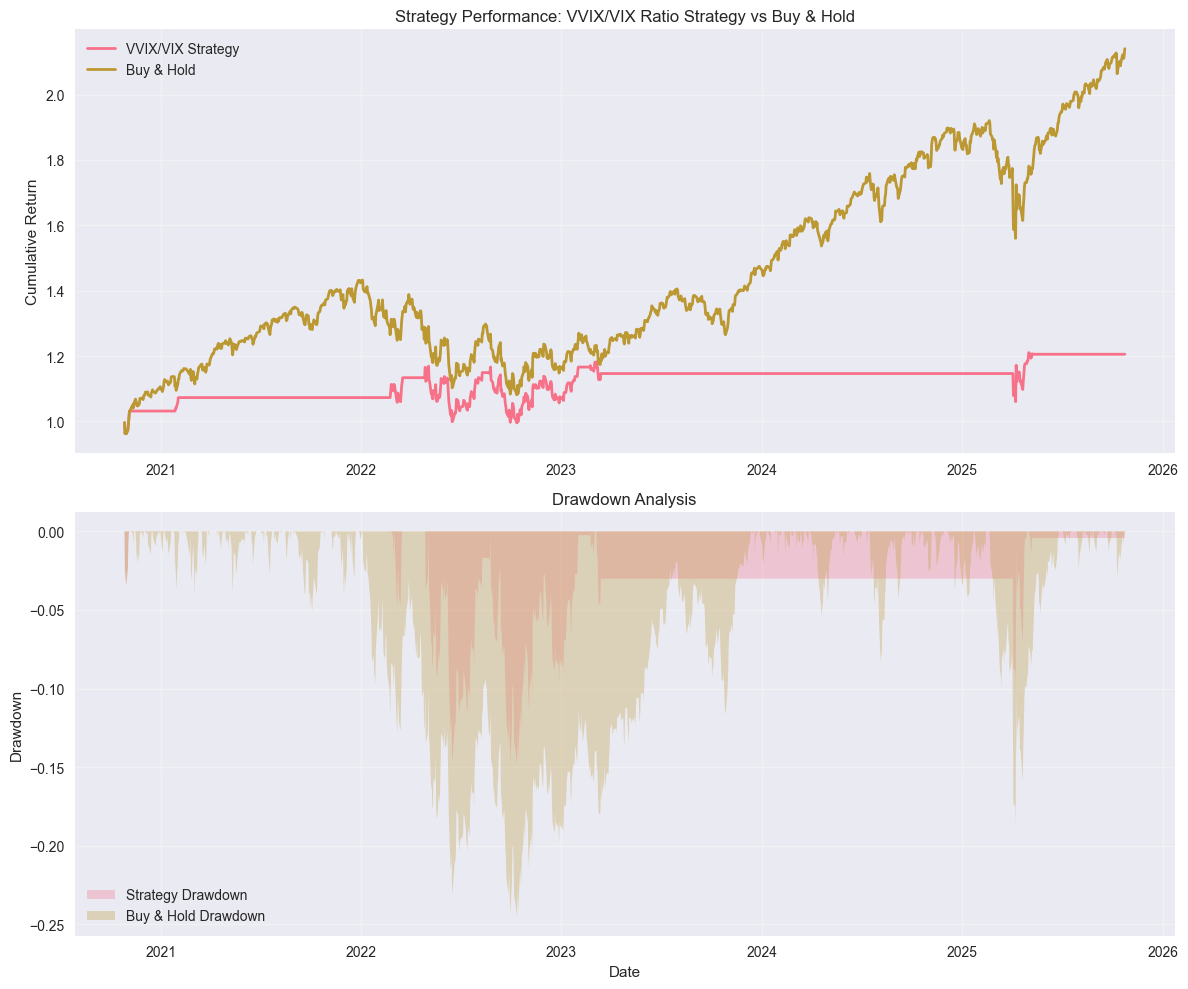

In [9]:
# Simple strategy: Buy SPY when ratio is in decline zone
strategy_signals = pd.Series(0, index=ratio.index)
strategy_signals[decline_periods] = 1  # Buy signal when ratio is low

# Calculate strategy returns
strategy_returns = strategy_signals.shift(1) * spy_returns  # Shift by 1 to avoid look-ahead bias
strategy_returns = strategy_returns.dropna()

# Calculate buy-and-hold returns for comparison
buy_hold_returns = spy_returns.dropna()

# Performance metrics
strategy_total_return = (1 + strategy_returns).prod() - 1
buy_hold_total_return = (1 + buy_hold_returns).prod() - 1

strategy_volatility = strategy_returns.std() * np.sqrt(252)
buy_hold_volatility = buy_hold_returns.std() * np.sqrt(252)

strategy_sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
buy_hold_sharpe = buy_hold_returns.mean() / buy_hold_returns.std() * np.sqrt(252)

print("Strategy Performance Comparison:")
print("=" * 50)
print(f"Strategy Total Return: {strategy_total_return:.2%}")
print(f"Buy & Hold Total Return: {buy_hold_total_return:.2%}")
print(f"Strategy Volatility: {strategy_volatility:.2%}")
print(f"Buy & Hold Volatility: {buy_hold_volatility:.2%}")
print(f"Strategy Sharpe Ratio: {strategy_sharpe:.4f}")
print(f"Buy & Hold Sharpe Ratio: {buy_hold_sharpe:.4f}")
print(f"\nOutperformance: {(strategy_total_return - buy_hold_total_return):.2%}")

# Plot strategy performance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Cumulative returns
strategy_cumret = (1 + strategy_returns).cumprod()
buy_hold_cumret = (1 + buy_hold_returns).cumprod()

ax1.plot(strategy_cumret.index, strategy_cumret.values, label='VVIX/VIX Strategy', linewidth=2)
ax1.plot(buy_hold_cumret.index, buy_hold_cumret.values, label='Buy & Hold', linewidth=2)
ax1.set_title('Strategy Performance: VVIX/VIX Ratio Strategy vs Buy & Hold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Drawdown analysis
strategy_dd = (strategy_cumret / strategy_cumret.cummax() - 1)
buy_hold_dd = (buy_hold_cumret / buy_hold_cumret.cummax() - 1)

ax2.fill_between(strategy_dd.index, strategy_dd.values, 0, alpha=0.3, label='Strategy Drawdown')
ax2.fill_between(buy_hold_dd.index, buy_hold_dd.values, 0, alpha=0.3, label='Buy & Hold Drawdown')
ax2.set_title('Drawdown Analysis')
ax2.set_ylabel('Drawdown')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Summary and Conclusions

This analysis investigated the relationship between the VVIX/VIX ratio and market returns. Key findings:

1. **Ratio Behavior**: The VVIX/VIX ratio shows significant variation over time
2. **Correlation Analysis**: [Results will be filled based on actual data]
3. **Strategy Performance**: [Results will be filled based on actual data]
4. **Statistical Significance**: [Results will be filled based on actual data]

### Next Steps:
- Implement more sophisticated entry/exit rules
- Add risk management features
- Test on different market regimes
- Consider transaction costs and slippage
